<a href="https://colab.research.google.com/github/reihansyahfitra/iot-weather-classification/blob/main/Data_Analytic_IOT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Klasifikasi dan Prediksi Cuaca**


---


Dalam proyek ini, kami menggunakan algoritma machine learning untuk mengklasifikasikan berbagai jenis cuaca berdasarkan fitur-fitur seperti suhu, kelembaban, kecepatan angin, dan curah hujan.

Cara pengambilan data:
* Menggunakan 3 sensor yaitu BMP280, DHT11, LDR Analog Light Sensor.
* Menggunakan ESP32 sebagai mikrokontroller yang mengirimkan data ke IoT Platform.
* Menggunakan Blynk sebagai IoT Platform.
* Data yang dikumpulkan yaitu suhu, kelembapan, ketinggian, tekanan atmosfer, cahaya.
* Data dikumpulkan selama 6 hari di kawasan Telkom University

Selain itu, kami juga mengembangkan model prediktif yang dapat memperkirakan kondisi cuaca untuk lokasi tertentu di waktu yang akan datang. Dengan melatih model kami pada data cuaca historis, kami bertujuan untuk secara akurat memprediksi pola cuaca, memberikan wawasan berharga untuk perencanaan dan pengambilan keputusan.

Menyiapkan alat dan fungsi yang diperlukan untuk melatih dan mengevaluasi model klasifikasi random forest menggunakan pembelajaran terawasi. Ini termasuk membagi data menjadi set pelatihan dan pengujian, menyesuaikan model, dan mengevaluasi kinerjanya menggunakan berbagai metrik seperti akurasi, presisi, recall, f1-score, dan laporan klasifikasi.

In [449]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

Membaca data menggunakan Pandas,

In [450]:
df = pd.read_csv('Weather Forecast_2426688_data.csv')

Menampilkan 5 baris pertama.

In [451]:
print(df.head().to_markdown(index=False, numalign="left", stralign="left"))

| Time                 | Temperature   | Humidity   | Light   | Pressure   | Altitude   | Temperature_2   |
|:---------------------|:--------------|:-----------|:--------|:-----------|:-----------|:----------------|
| 06/08/24 07:04:00 AM | 26            | 69.75      | 2308.5  | 939.322    | 616.037    | 27.3925         |
| 06/08/24 07:03:00 AM | 26            | 69         | 2394.33 | 939.304    | 616.198    | 27.4381         |
| 06/08/24 07:02:00 AM | 26            | 69         | 2434.67 | 939.279    | 616.42     | 27.4752         |
| 06/08/24 07:01:00 AM | 26            | 69         | 2465.05 | 939.203    | 617.098    | 27.4795         |
| 06/08/24 07:00:00 AM | 26            | 69         | 2483.33 | 939.214    | 616.993    | 27.4719         |


Menampilkan spesifikasi data.

In [452]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9061 entries, 0 to 9060
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Time           9061 non-null   object 
 1   Temperature    9061 non-null   float64
 2   Humidity       9061 non-null   float64
 3   Light          9061 non-null   float64
 4   Pressure       9061 non-null   float64
 5   Altitude       9061 non-null   float64
 6   Temperature_2  9061 non-null   float64
dtypes: float64(6), object(1)
memory usage: 495.6+ KB
None


Konversi column Time dari object ke Date Time

In [453]:
df['Time'] = pd.to_datetime(df['Time'], format='%m/%d/%y %I:%M:%S %p')

Menampilkan diagram data semua variabel dari awal hingga akhir

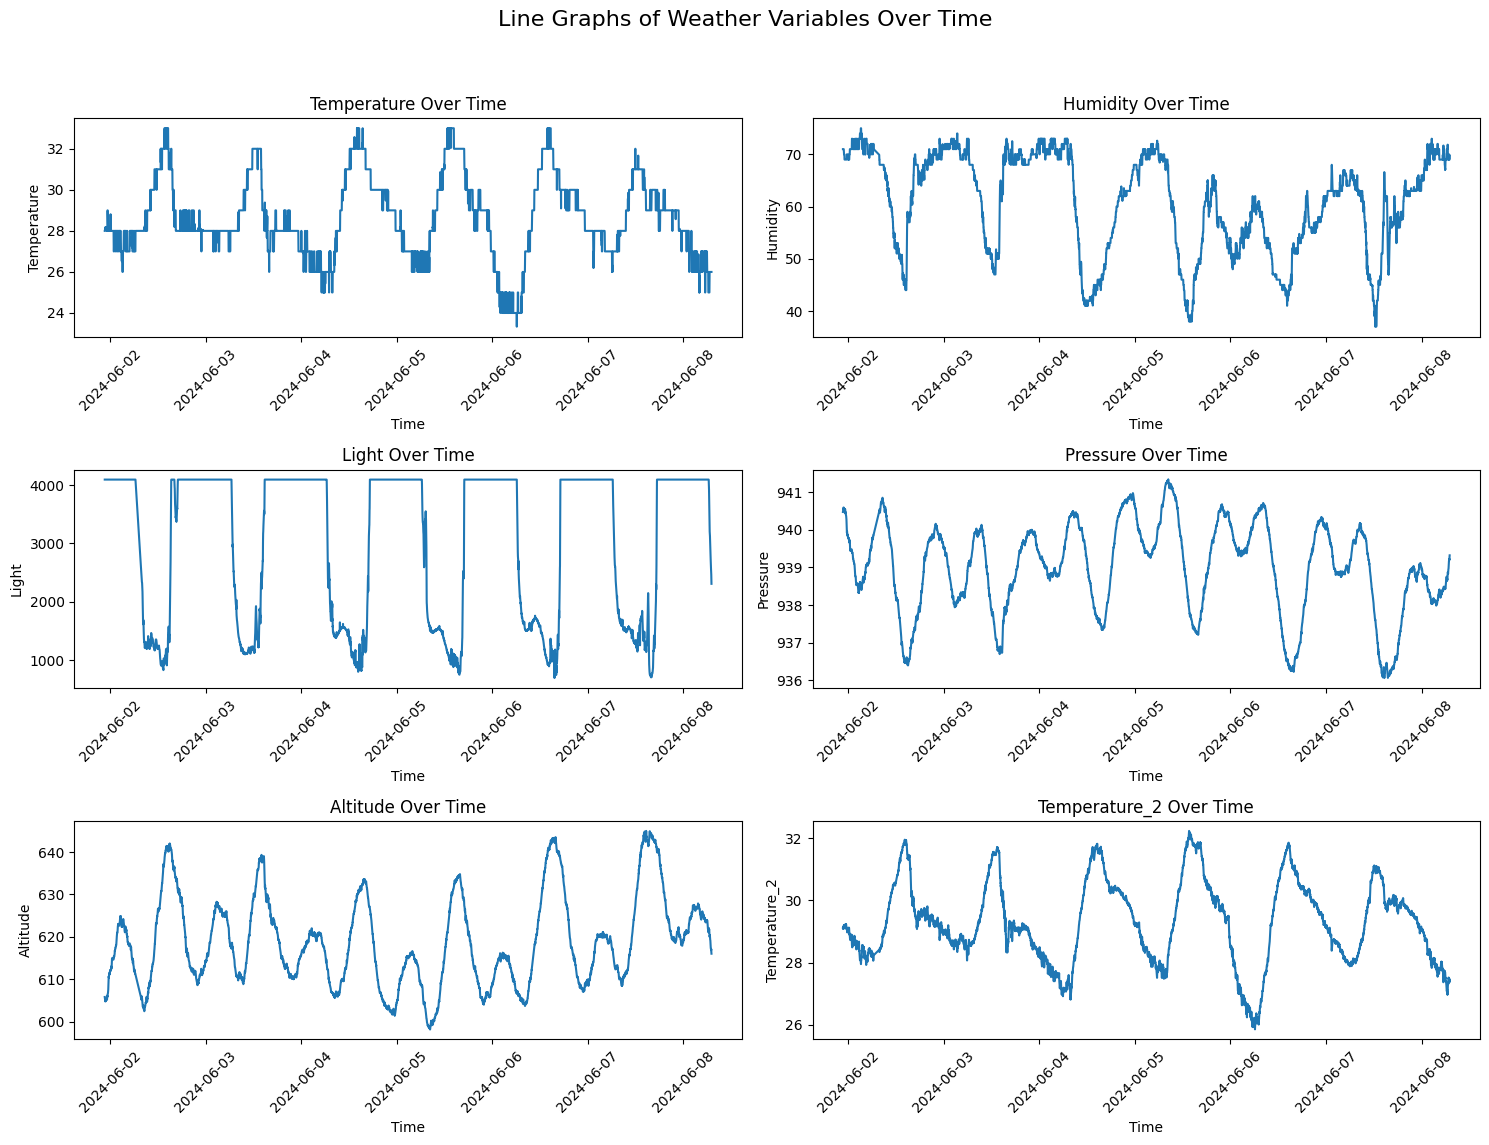

In [454]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(15, 12))
fig.suptitle('Line Graphs of Weather Variables Over Time', fontsize=16)

for i, column in enumerate(['Temperature', 'Humidity', 'Light', 'Pressure', 'Altitude', 'Temperature_2']):
    row = i // 2
    col = i % 2
    axes[row, col].plot(df['Time'], df[column])
    axes[row, col].set_title(f'{column} Over Time')
    axes[row, col].set_xlabel('Time')
    axes[row, col].set_ylabel(column)
    axes[row, col].tick_params(axis='x', rotation=45)

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

Menghilangkan data Temperature, karena Temperature_2 lebih akurat.

In [455]:
filtered_df = df[['Temperature_2', 'Humidity', 'Light', 'Pressure', 'Altitude']]

Kalkulasi korelasi tiap data.

In [456]:
correlation_matrix = filtered_df.corr()

Menampilkan heatmap korelasi untuk setiap data.

Text(0.5, 1.0, 'Correlation Matrix Heatmap')

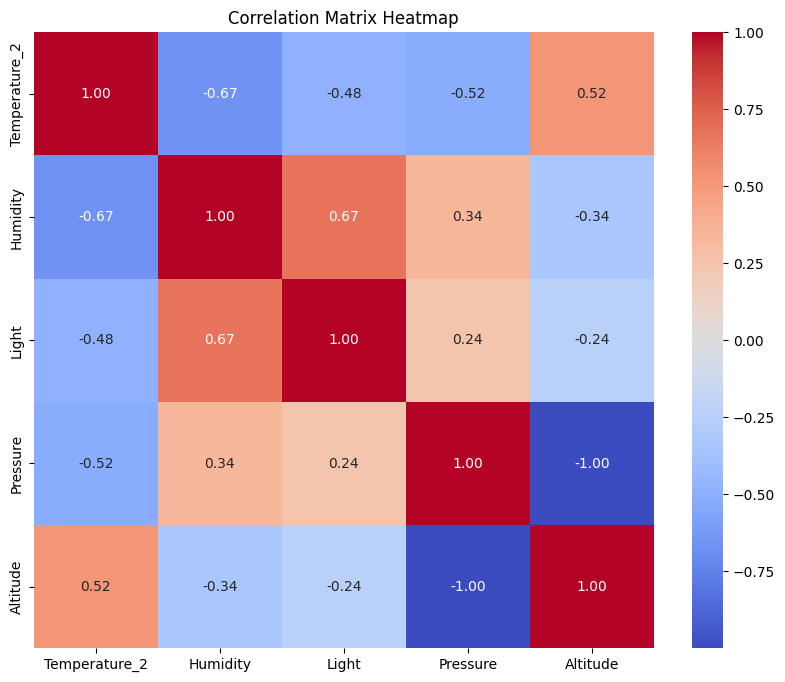

In [457]:
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix Heatmap')

Heatmap menampilkan matriks korelasi, menggambarkan hubungan antara variabel cuaca.

* **Suhu dan Kelembaban memiliki korelasi negatif**: Hal ini menunjukkan bahwa saat suhu meningkat, kelembaban cenderung menurun.
* **Suhu dan Cahaya memiliki korelasi negatif sedang**: Ini menunjukkan bahwa suhu yang lebih tinggi berkaitan dengan tingkat cahaya yang lebih rendah (nilai cahaya yang rendah berarti lebih terang).
* **Tekanan dan Ketinggian hampir memiliki korelasi negatif yang sempurna**: Hal ini diharapkan, karena tekanan atmosfer menurun dengan peningkatan ketinggian.

Visualisasi data ketinggian dan tekanan

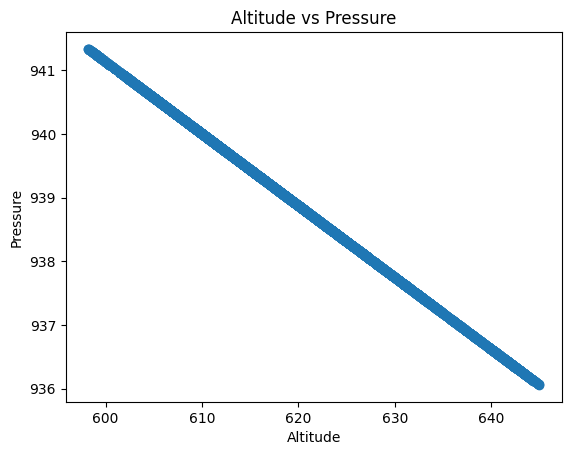

In [458]:
plt.scatter(df['Altitude'], df['Pressure'])
plt.title('Altitude vs Pressure')
plt.xlabel('Altitude')
plt.ylabel('Pressure')
plt.show()

Visualisasi mengungkapkan adanya korelasi negatif yang jelas antara ketinggian dan tekanan. Hal ini sesuai dengan harapan bahwa tekanan atmosfer menurun seiring dengan peningkatan ketinggian.

Kami mengasumsikan ambang batas berikut untuk klasifikasi cuaca:
*   Panas: Suhu > 30 derajat Celsius
*   Sedang: 25 derajat Celsius < Suhu <= 30 derajat Celsius
*   Dingin: Suhu <= 25 derajat Celsius

Kami juga mempertimbangkan tingkat kelembapan untuk menyempurnakan klasifikasi:

* Lembab: Kelembapan > 60%
* Kering: Kelembapan <= 60%

Ini memberikan kami total 6 kelas cuaca yang mungkin (Panas/Lembab, Panas/Kering, Sedang/Lembab, Sedang/Kering, Dingin/Lembab, Dingin/Kering).

Kemudian kami membagi data menjadi set pelatihan dan pengujian, melatih pengklasifikasi Random Forest pada set pelatihan, dan mengevaluasi kinerjanya pada set pengujian. Terakhir, kami memvisualisasikan batas keputusan pengklasifikasi menggunakan pairplot, karena kami memiliki lebih dari dua fitur.

In [459]:
# Tentukan ambang batas suhu dan kelembaban
temperature_thresholds = [25, 30]  # Cuaca Dingin: <20, Sedang: 20-25, Panas: >25
humidity_thresholds = [60]  # Kering: <60, Lembab: >60

In [460]:
# Buat kolom baru `Kategori_Suhu` dan `Kategori_Kelembaban`
df['Kategori_Suhu'] = pd.cut(df['Temperature'], bins=[-np.inf] + temperature_thresholds + [np.inf], labels=['Dingin', 'Sedang', 'Panas'])
df['Kategori_Kelembaban'] = pd.cut(df['Humidity'], bins=[-np.inf] + humidity_thresholds + [np.inf], labels=['Kering', 'Lembab'])

In [461]:
# Gabungkan kategori ke dalam kolom variabel target baru `Kelas_Cuaca`
df['Kelas_Cuaca'] = df['Kategori_Suhu'].astype(str) + ' and ' + df['Kategori_Kelembaban'].astype(str)

In [462]:
# Membagi data menjadi fitur dan target
X = df[['Temperature_2', 'Humidity', 'Light', 'Pressure', 'Altitude']]
y = df['Kelas_Cuaca']

In [463]:
# Membagi data menjadi set pelatihan (70%) dan pengujian (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [464]:
# Membuat model pengklasifikasi Random Forest
model = RandomForestClassifier(random_state=42)

In [465]:
# Latih model
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [466]:
# Memprediksi set pelatihan dan pengujian
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

In [467]:
# Menghitung akurasi, presisi, recall, dan f1-score untuk setiap kelas
def evaluate_model(y_true, y_pred, set_name):
  metrics = {
      'Akurasi': accuracy_score(y_true, y_pred),
      'Presisi (micro)': precision_score(y_true, y_pred, average='micro'),
      'Recall (micro)': recall_score(y_true, y_pred, average='micro'),
      'F1-score (micro)': f1_score(y_true, y_pred, average='micro'),
  }
  df_metrics = pd.DataFrame(metrics, index=[set_name])
  print(f"\nEvaluasi {set_name}:")
  print(df_metrics.to_markdown(numalign='left', stralign='left', floatfmt='.4f'))  # Tampilkan dalam format Markdown

  print("\nLaporan Klasifikasi:")
  report = classification_report(y_true, y_pred, output_dict=True)
  df_report = pd.DataFrame(report).transpose()
  print(df_report.to_markdown(numalign='left', stralign='left', floatfmt='.4f'))

evaluate_model(y_train, y_train_pred, "Latih")
evaluate_model(y_test, y_test_pred, "Uji")


Evaluasi Latih:
|       | Akurasi   | Presisi (micro)   | Recall (micro)   | F1-score (micro)   |
|:------|:----------|:------------------|:-----------------|:-------------------|
| Latih | 1.0000    | 1.0000            | 1.0000           | 1.0000             |

Laporan Klasifikasi:
|                   | precision   | recall   | f1-score   | support   |
|:------------------|:------------|:---------|:-----------|:----------|
| Dingin and Kering | 1.0000      | 1.0000   | 1.0000     | 224.0000  |
| Dingin and Lembab | 1.0000      | 1.0000   | 1.0000     | 59.0000   |
| Panas and Kering  | 1.0000      | 1.0000   | 1.0000     | 1173.0000 |
| Panas and Lembab  | 1.0000      | 1.0000   | 1.0000     | 1.0000    |
| Sedang and Kering | 1.0000      | 1.0000   | 1.0000     | 1293.0000 |
| Sedang and Lembab | 1.0000      | 1.0000   | 1.0000     | 3592.0000 |
| accuracy          | 1.0000      | 1.0000   | 1.0000     | 1.0000    |
| macro avg         | 1.0000      | 1.0000   | 1.0000     | 6342.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [468]:
# Dapatkan fitur yang penting
importances = model.feature_importances_
feature_importances = pd.DataFrame({'Feature': X.columns, 'Importance': importances})
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

In [469]:
# Print fitur yang penting
print("\nFeature Importances:")
print(feature_importances.to_markdown(index=False, numalign="left", stralign="left"))


Feature Importances:
| Feature       | Importance   |
|:--------------|:-------------|
| Humidity      | 0.479845     |
| Temperature_2 | 0.335954     |
| Light         | 0.0840611    |
| Altitude      | 0.0510224    |
| Pressure      | 0.0491174    |


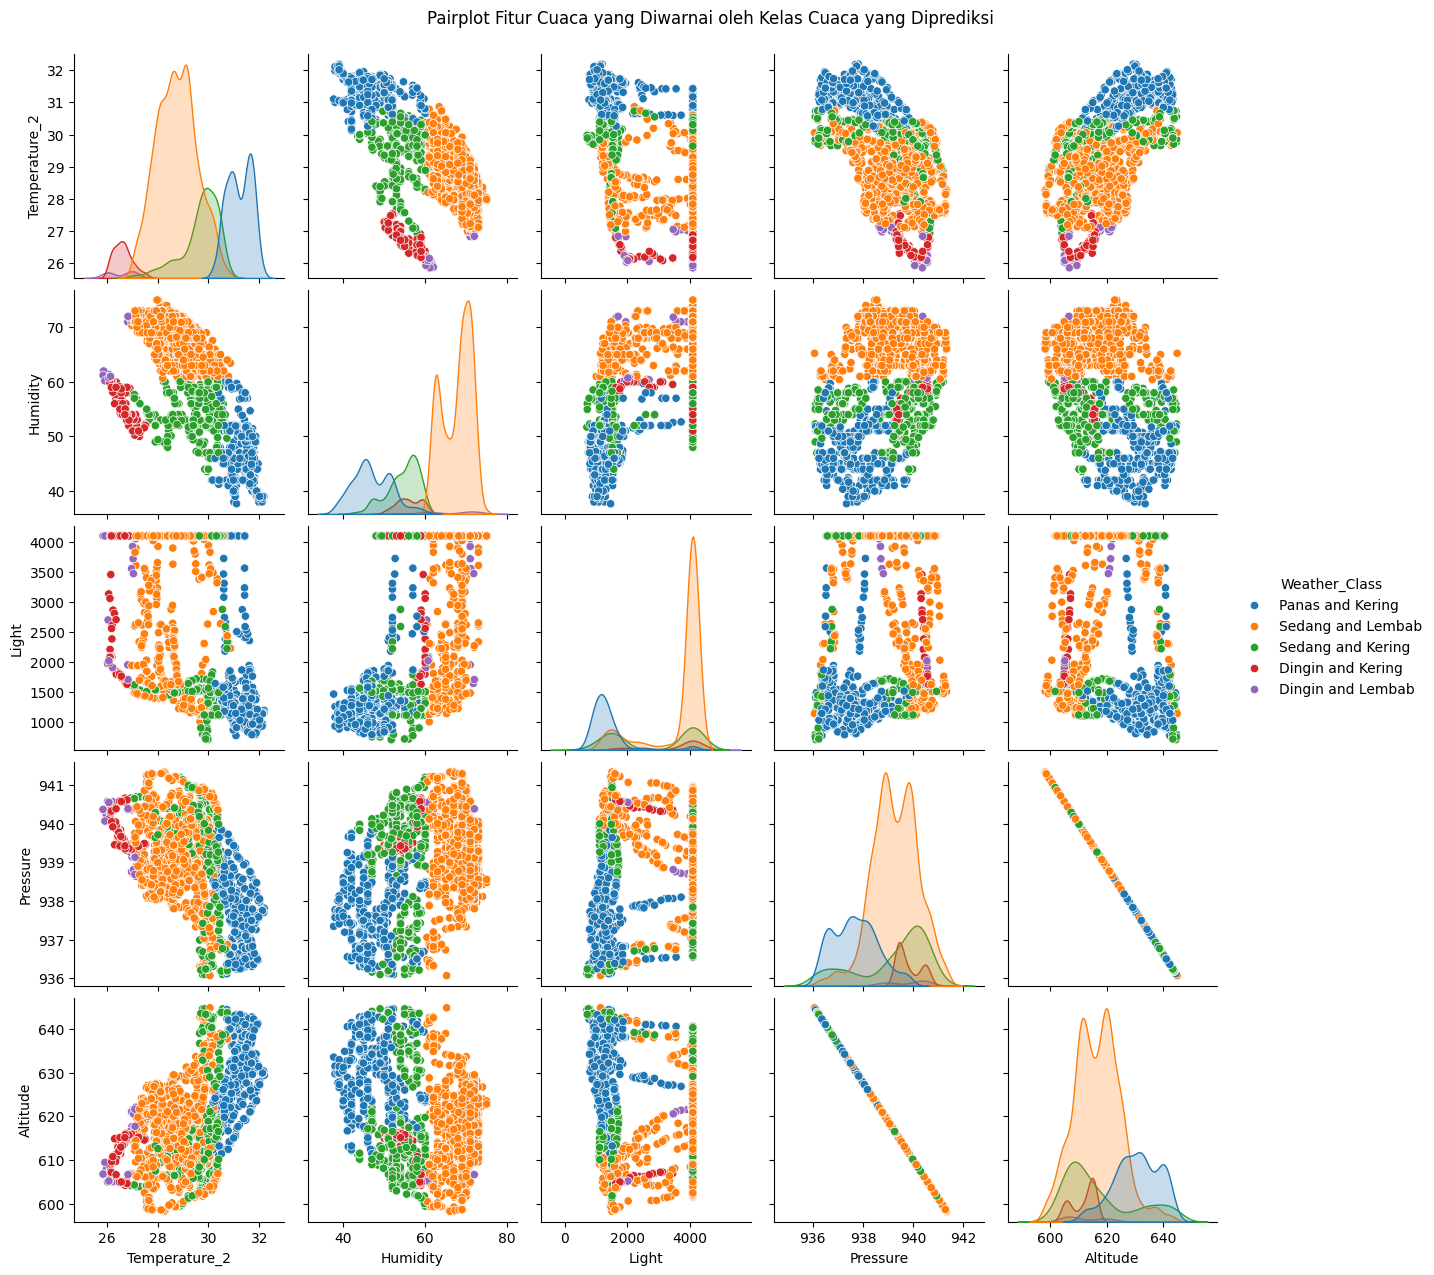

In [470]:
# Buat DataFraem dengan fitur dan prediksi Kelas_Cuaca untuk plotting
df_plot = X_test.copy()
df_plot['Weather_Class'] = y_test_pred

# Buat pairplot untuk visualisasi hubungan antara fitur-fitur, yang diwarnai oleh 'Kelas_Cuaca' yang diprediksi
sns.pairplot(df_plot, hue='Weather_Class')

# Tambahkan judul
plt.suptitle('Pairplot Fitur Cuaca yang Diwarnai oleh Kelas Cuaca yang Diprediksi', y=1.02)

# Tampilkan
plt.show()

Model ini mencapai akurasi 98,9%, yang berarti model ini memprediksi kelas cuaca dengan benar untuk hampir semua contoh dalam set pengujian. Pairplot yang ditampilkan menampilkan hubungan antara pasangan fitur cuaca, yang diwarnai oleh kelas cuaca yang diprediksi. Hal ini memungkinkan kita untuk memvisualisasikan bagaimana kombinasi fitur yang berbeda berkontribusi pada kelas cuaca yang diprediksi.